In [1]:
from bayes3d.dino import Dino
import bayes3d as b
import os
import torch
import numpy as np
import matplotlib
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torchvision.transforms as T
import bayes3d.ycb_loader
import bayes3d.o3d_viz

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dinov2_vitg14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')
dino = dinov2_vitg14.to(device)  # Same issue with larger model
feat_dim = 1536 # vitg14


def get_embeddings(rgbd):
    img = b.get_rgb_image(rgbd.rgb).convert('RGB')
    patch_h, patch_w = np.array(img.size) // 14
    transform = T.Compose([
        T.GaussianBlur(9, sigma=(0.1, 2.0)),
        T.Resize((patch_h * 14, patch_w * 14)),
        T.CenterCrop((patch_h * 14, patch_w * 14)),
        T.ToTensor(),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])
    tensor = transform(img)[:3].unsqueeze(0).to(device)
    with torch.no_grad():
        features_dict = dinov2_vitg14.forward_features(tensor)
        features = features_dict['x_norm_patchtokens'][0].reshape((patch_h, patch_w, feat_dim)).permute(2, 0, 1).unsqueeze(0)
    print(features.shape)
    img_feat_norm = torch.nn.functional.normalize(features, dim=1)
    output = jnp.array(img_feat_norm.cpu().detach().numpy())[0]
    del img_feat_norm
    del features
    del tensor
    del features_dict
    torch.cuda.empty_cache()
    return output

Using cache found in /home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main
xFormers not available
xFormers not available


In [4]:
h = 1400
intrinsics = b.Intrinsics(
    height=h,
    width=h,
    fx=3300.0, fy=3300.0,
    cx=h/2.0, cy=h/2.0,
    near=0.001, far=6.0
)


In [5]:
viz = b.o3d_viz.O3DVis(intrinsics)

[Open3D INFO] EGL headless mode enabled.


In [6]:
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
mesh_paths = []
for idx in range(1,22):
    mesh_paths.append(os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply"))
SCALING_FACTOR = 1.0/1000.0

In [8]:
    mesh = o3d.io.read_triangle_model(mesh_filename)


[Open3D WARNING] Unable to load file /home/ubuntu/nishad/bayes3d/assets/bop/ycbv/models/obj_000003.ply with ASSIMP


In [7]:
import open3d as o3d
rendered_images = []
object_poses = []
mesh_filename = mesh_paths[2]

num_images = 10
keys = jax.random.split(jax.random.PRNGKey(5), num_images)
for angle in jnp.linspace(0.0, jnp.pi * 2, 8)[:-1]:
    viz.clear()
    mesh = o3d.io.read_triangle_model(mesh_filename)
    pose = b.t3d.inverse_pose(b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 0.6, 0.0]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )) @ b.t3d.transform_from_axis_angle(jnp.array([0.0, 0.0, 1.0]), angle)
    object_poses.append(pose)

    mesh.meshes[0].mesh.scale(SCALING_FACTOR, np.array([0.0, 0.0, 0.0]))
    mesh.meshes[0].mesh.transform(pose)
    viz.render.scene.add_model(f"1", mesh)

    rendered_rgbd = viz.capture_image(intrinsics, jnp.eye(4))
    rendered_images.append(rendered_rgbd)

scaled_down_rendered_images = [b.scale_rgbd(r, 1.0/14.0) for r in rendered_images]
b.hstack_images([b.get_rgb_image(r.rgb) for r in rendered_images])


[Open3D WARNING] Unable to load file /home/ubuntu/nishad/bayes3d/assets/bop/ycbv/models/obj_000003.ply with ASSIMP


IndexError: list index out of range

In [12]:
embeddings = [get_embeddings(i) for i in rendered_images]
masks = [jnp.inf != i.depth for i in scaled_down_rendered_images]
pixel_coords = [jnp.vstack(jnp.where(m)) for m in masks]

/home/nishadgothoskar/anaconda3/envs/bayes3d/lib/python3.8/site-packages/xformers/ops/unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
/home/nishadgothoskar/anaconda3/envs/bayes3d/lib/python3.8/site-packages/xformers/ops/unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:


torch.Size([1, 1536, 100, 100])
torch.Size([1, 1536, 100, 100])
torch.Size([1, 1536, 100, 100])
torch.Size([1, 1536, 100, 100])
torch.Size([1, 1536, 100, 100])
torch.Size([1, 1536, 100, 100])
torch.Size([1, 1536, 100, 100])


In [13]:
%%time
point_cloud_images = [b.t3d.unproject_depth_jit(image.depth,image.intrinsics) for image in scaled_down_rendered_images]


CPU times: user 69.9 ms, sys: 4.71 ms, total: 74.6 ms
Wall time: 109 ms


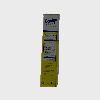

In [15]:
b.get_rgb_image(scaled_down_rendered_images[0].rgb)

In [16]:
key = jax.random.PRNGKey(10)

In [17]:
# Identifying informative descriptors

sparse_descriptors = []
for t1 in range(len(embeddings)):
    for t2 in range(len(embeddings)):
        if t1 == t2:
            continue
        print("t1,t2", (t1,t2))
        
        keys = jax.random.split(key)[1]
        pixel_coords_subsampled = pixel_coords[t1][:,jax.random.choice(key, pixel_coords[t1].shape[1], (300,))]
        
        selected_embeddings = embeddings[t1][:, pixel_coords_subsampled[0], pixel_coords_subsampled[1]]
        
        similarity = jnp.einsum("iab, ik->abk", embeddings[t2], selected_embeddings)
        max_similarities = similarity.max([0,1])
        high_match_indices = (max_similarities > 0.98)

        print(high_match_indices.sum())
        high_match_embeddings = selected_embeddings[:, high_match_indices]

        high_match_pixel_coords = pixel_coords_subsampled[:, high_match_indices]
        point_cloud_image = b.t3d.unproject_depth(scaled_down_rendered_images[t1].depth, scaled_down_rendered_images[t1].intrinsics)
        high_match_3d_coords = b.t3d.apply_transform(point_cloud_image[high_match_pixel_coords[0], high_match_pixel_coords[1],:],
                                                     b.t3d.inverse_pose(object_poses[t1]))

        sparse_descriptors.append((high_match_3d_coords, high_match_embeddings, high_match_pixel_coords, jnp.full(high_match_embeddings.shape[1],t1)))
        

t1,t2 (0, 1)
0


/home/nishadgothoskar/bayes3d/bayes3d/transforms_3d.py:206: RuntimeWarning: invalid value encountered in multiply
  depth = depth * mask + intrinsics.far * (1.0 - mask)


t1,t2 (0, 2)
0
t1,t2 (0, 3)
0
t1,t2 (0, 4)
0
t1,t2 (0, 5)
0
t1,t2 (0, 6)
0
t1,t2 (1, 0)
0
t1,t2 (1, 2)
6
t1,t2 (1, 3)
0
t1,t2 (1, 4)
0
t1,t2 (1, 5)
0
t1,t2 (1, 6)
0
t1,t2 (2, 0)
0
t1,t2 (2, 1)
2
t1,t2 (2, 3)
0
t1,t2 (2, 4)
0
t1,t2 (2, 5)
0
t1,t2 (2, 6)
0
t1,t2 (3, 0)
0
t1,t2 (3, 1)
0
t1,t2 (3, 2)
0
t1,t2 (3, 4)
0
t1,t2 (3, 5)
0
t1,t2 (3, 6)
0
t1,t2 (4, 0)
0
t1,t2 (4, 1)
0
t1,t2 (4, 2)
0
t1,t2 (4, 3)
0
t1,t2 (4, 5)
0
t1,t2 (4, 6)
0
t1,t2 (5, 0)
0
t1,t2 (5, 1)
0
t1,t2 (5, 2)
0
t1,t2 (5, 3)
0
t1,t2 (5, 4)
0
t1,t2 (5, 6)
1
t1,t2 (6, 0)
0
t1,t2 (6, 1)
0
t1,t2 (6, 2)
0
t1,t2 (6, 3)
0
t1,t2 (6, 4)
0
t1,t2 (6, 5)
1


In [18]:
all_3d_coords = jnp.vstack([i[0] for i in sparse_descriptors])
all_embeddings = jnp.concatenate([i[1] for i in sparse_descriptors],axis=1)
all_pixel_coords = jnp.concatenate([i[2] for i in sparse_descriptors],axis=1)
all_timesteps = jnp.concatenate([i[3] for i in sparse_descriptors])
print(all_3d_coords.shape, all_embeddings.shape)

(10, 3) (1536, 10)


In [24]:
def x_marks_the_spot_viz(ii,jj,border=0):
    point = jnp.zeros(scaled_down_rendered_images[0].rgb.shape[:2])
    point = point.at[ii-border:ii+border+1,jj-border:jj+border+1].set(1.0)
    point_img =b.get_depth_image(point)   
    return point_img

def x_marks_the_spot_overlay_viz(ii,jj, image):
    rgb_viz = b.get_rgb_image(image.rgb)
    return b.overlay_image(x_marks_the_spot_viz(ii,jj), rgb_viz,0.2)


def viz_desciptor(descriptor_idx):
    t1 = all_timesteps[descriptor_idx]
    ii,jj = all_pixel_coords[:,descriptor_idx]
    return x_marks_the_spot_overlay_viz(ii,jj,scaled_down_rendered_images[t1])    

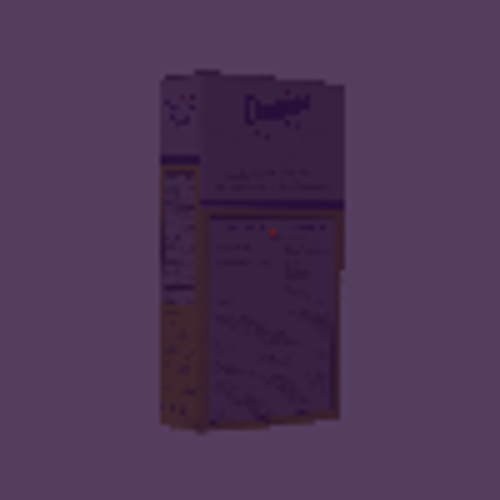

In [25]:
b.scale_image(viz_desciptor(12),5.0)

torch.Size([1, 1536, 100, 100])


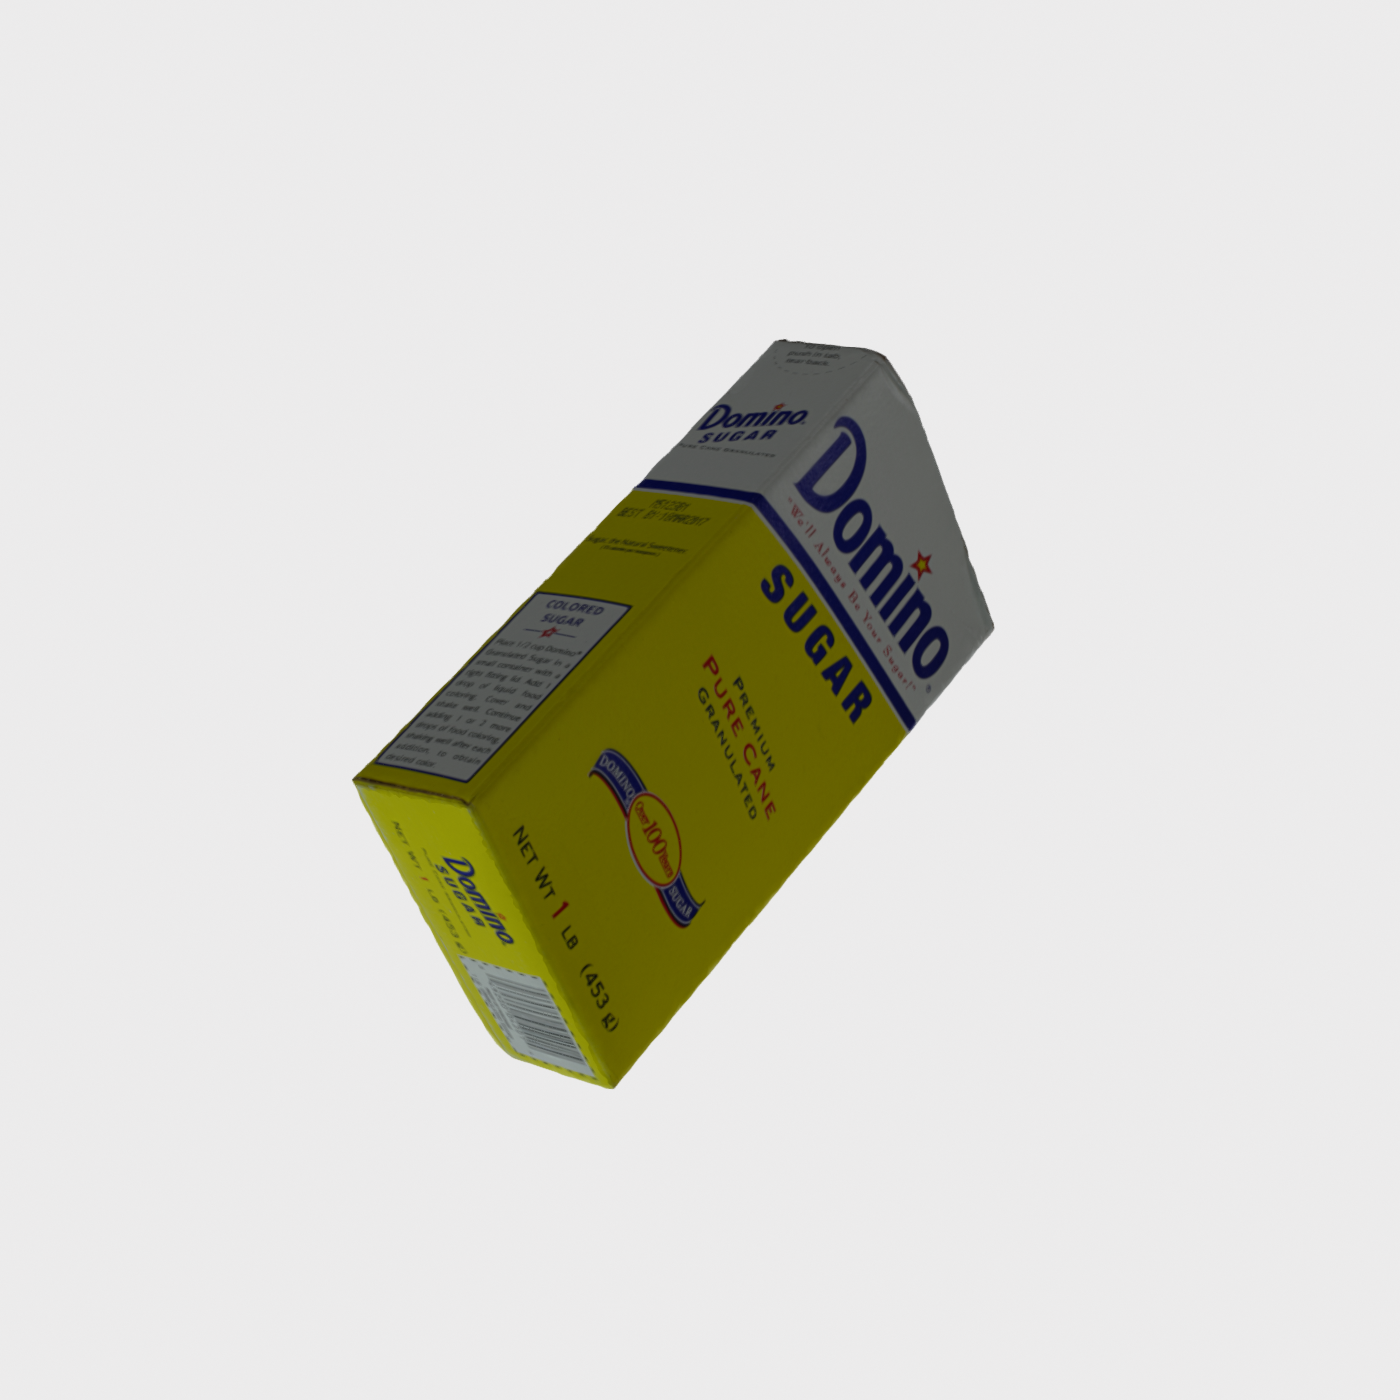

In [38]:
viz.clear()
mesh = o3d.io.read_triangle_model(mesh_filename)
pose = b.distributions.gaussian_vmf_sample(
    jax.random.PRNGKey(1),
    b.t3d.inverse_pose(b.t3d.transform_from_pos_target_up(
    jnp.array([0.0, 0.8, 0.0]),
    jnp.array([0.0, 0.0, 0.0]),
    jnp.array([0.0, 0.0, 1.0]),
)), 0.0001, 0.0001)
mesh.meshes[0].mesh.scale(SCALING_FACTOR, np.array([0.0, 0.0, 0.0]))
mesh.meshes[0].mesh.transform(pose)
viz.render.scene.add_model(f"1", mesh)

original_test_rgbd = viz.capture_image(intrinsics, jnp.eye(4))
target_embeddings = get_embeddings(original_test_rgbd)
test_rgbd = b.scale_rgbd(original_test_rgbd, 1.0/14.0)

similarity = jnp.einsum("iab, ik->abk", target_embeddings, all_embeddings)
order = jnp.argsort(-similarity.max([0,1]))
b.get_rgb_image(original_test_rgbd.rgb)

0.38069212
51 32


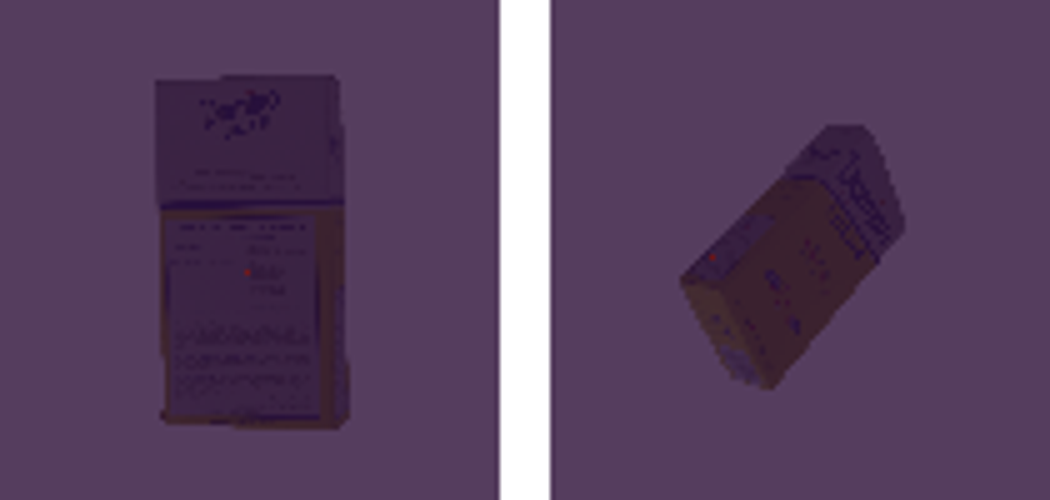

In [50]:
descriptor_idx = order[12]
# descriptor_idx = 12
print(similarity[:,:,descriptor_idx].max())
ii,jj = jnp.unravel_index(similarity[:,:,descriptor_idx].argmax(), similarity[:,:,descriptor_idx].shape)
print(ii,jj)

b.scale_image(b.hstack_images([viz_desciptor(descriptor_idx),x_marks_the_spot_overlay_viz(ii,jj, test_rgbd)]),5)

In [59]:
good_indices = jnp.arange(2,20)
good_descriptors = order[good_indices]
good_3d_points = all_3d_coords[good_descriptors]

matched_3d_points = []
point_cloud_image = b.t3d.unproject_depth(test_rgbd.depth, test_rgbd.intrinsics)
for descriptor_idx in good_descriptors:
    print(similarity[:,:,descriptor_idx].max())
    ii,jj = jnp.unravel_index(similarity[:,:,descriptor_idx].argmax(), similarity[:,:,descriptor_idx].shape)
    matched_3d_points.append(point_cloud_image[ii,jj])
matched_3d_points = jnp.array(matched_3d_points)
b.clear()
b.show_cloud("1", good_3d_points,color=b.BLUE)
b.show_cloud("2", point_cloud_image.reshape(-1,3))
b.show_cloud("3", matched_3d_points,color=b.RED)

best_tranform =find_least_squares_transform_between_clouds(good_3d_points, matched_3d_points)
print(best_tranform)
b.clear()
b.show_cloud("1", b.t3d.apply_transform_jit(good_3d_points, best_tranform),color=b.BLUE)
b.show_cloud("3", matched_3d_points,color=b.RED)

b.clear()
mesh = b.mesh.load_mesh(mesh_filename, SCALING_FACTOR)
b.show_cloud("2", point_cloud_image.reshape(-1,3))
b.show_trimesh("1",mesh)
b.set_pose("1", best_tranform)
b.show_trimesh("original",mesh)
b.show_cloud("matched", good_3d_points,color=b.BLUE)
b.show_cloud("3", matched_3d_points,color=b.RED)

# b.show_trimesh("original_mesh",mesh)



0.86874855
0.836698
0.826195
0.82264644
0.8216182
0.7875354
0.77848554
0.38069212
0.38069212
0.38069212
0.38069212
0.38069212
0.38069212
0.38069212
0.38069212
0.38069212
0.38069212
0.38069212
[[ 0.94977766 -0.13334057  0.28333613 -0.01876103]
 [ 0.2623092   0.8332257  -0.48686433  0.00173127]
 [-0.1711452   0.5366894   0.82605064  0.7622807 ]
 [ 0.          0.          0.          1.        ]]


In [ ]:
bestmesh_tranform

In [52]:
def find_least_squares_transform_between_clouds(c1, c2):
    centroid1 = jnp.mean(c1, axis=0) 
    centroid2 = jnp.mean(c2, axis=0)
    c1_centered = c1 - centroid1
    c2_centered = c2 - centroid2
    H = jnp.transpose(c1_centered).dot(c2_centered)

    U,_,V = jnp.linalg.svd(H)
    rot = (jnp.transpose(V).dot(jnp.transpose(U)))

    modifier = jnp.array([
        [1.0, 0.0, 0.0],
        [0.0, 1.0, 0.0],
        [0.0, 0.0, -1.0],
    ])
    V_mod = modifier.dot(V)
    rot2 = (jnp.transpose(V_mod).dot(jnp.transpose(U)))

    rot_final = (jnp.linalg.det(rot) < 0) * rot2 + (jnp.linalg.det(rot) > 0) * rot

    T = (centroid2 - rot_final.dot(centroid1))
    transform =  b.t3d.transform_from_rot_and_pos(rot_final, T)
    return transform

In [ ]:
b.clear()
b.show_cloud("2", b.t3d.unproject_depth(test_rgbd.depth, test_rgbd.intrinsics).reshape(-1,3))

In [187]:
b.clear()

b.show_cloud("1",all_3d_coords)

In [ ]:
t1,t2 = 1,2
keys = jax.random.split(key)[1]
ii,jj = coords[t1][:,jax.random.choice(key, coords[t1].shape[1], (50,))]
selected_embedding = embeddings[t1][:,ii,jj]
print(ii,jj)
similarity = jnp.einsum("iab, ik->abk", embeddings[t2], selected_embedding)
similarity_img = b.get_depth_image(similarity, min=-1.0, max=1.0)

iii,jjj = jnp.unravel_index(similarity.argmax(), similarity.shape)

point = jnp.zeros_like(similarity)
point = point.at[ii-4:ii+4,jj-4:jj+4].set(1.0)
point_img =b.get_depth_image(point)


point2 = jnp.zeros_like(similarity)
point2 = point2.at[iii-4:iii+4,jjj-4:jjj+4].set(1.0)
point2_img =b.get_depth_image(point2)

print(similarity.max())

b.hstack_images([b.overlay_image(point_img,b.get_rgb_image(rendered_images[t1].rgb), 0.4),
                 b.overlay_image(point2_img,b.get_rgb_image(rendered_images[t2].rgb), 0.4),
                 b.overlay_image(similarity_img,b.get_rgb_image(rendered_images[t2].rgb)),
                 similarity_img,
                 ])

In [ ]:


mask_ = 1.0 * mask
mask_ = mask_.at[ii-4:ii+4,jj-4:jj+4].set(2.0)
b.get_depth_image(mask_)
selected_embedding = embeddings[:,ii,jj]
similarity1 = jnp.einsum("iab, i->ab", embeddings, selected_embedding)
v1 = b.get_depth_image(similarity1, min=-1.0, max=1.0)
r1 = b.get_rgb_image(rgbd.rgb)

similarity2 = jnp.einsum("iab, i->ab", embeddings2, selected_embedding)
v2 = b.get_depth_image(similarity2, min=-1.0, max=1.0)
r2 = b.get_rgb_image(rgbd2.rgb)
b.hstack_images(
    [r1, b.get_depth_image(mask_), b.overlay_image(r1, b.get_depth_image(mask_)), r2,v2,b.overlay_image(r2,v2, alpha=0.8)]
)

In [40]:
rendered_rgbd.segmentation

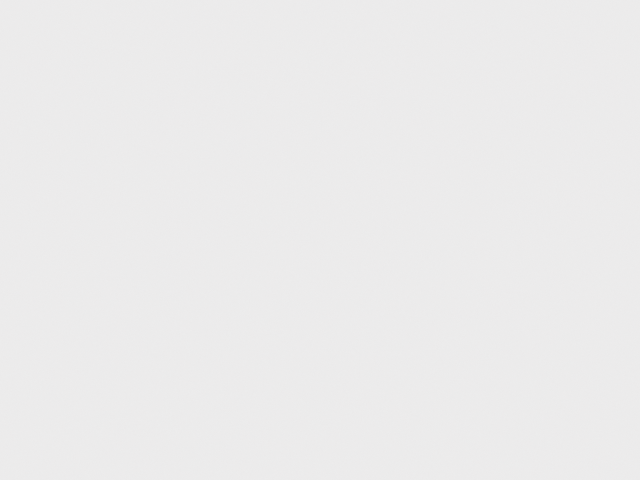

In [7]:
viz.make_mesh_from_file(mesh_paths[2], ), scaling_factor=1.0/1000.0)

TypeError: scale(): incompatible function arguments. The following argument types are supported:
    1. (self: open3d.cuda.pybind.geometry.Geometry3D, scale: float, center: numpy.ndarray[numpy.float64[3, 1]]) -> open3d.cuda.pybind.geometry.Geometry3D
    2. (self: open3d.cuda.pybind.geometry.Geometry3D, scale: float, center: numpy.ndarray[numpy.float64[3, 1]]) -> open3d.cuda.pybind.geometry.Geometry3D

Invoked with: TriangleMesh with 8300 points and 15728 triangles., 0.001

torch.Size([1, 1536, 45, 34])
torch.Size([1, 1536, 45, 34])


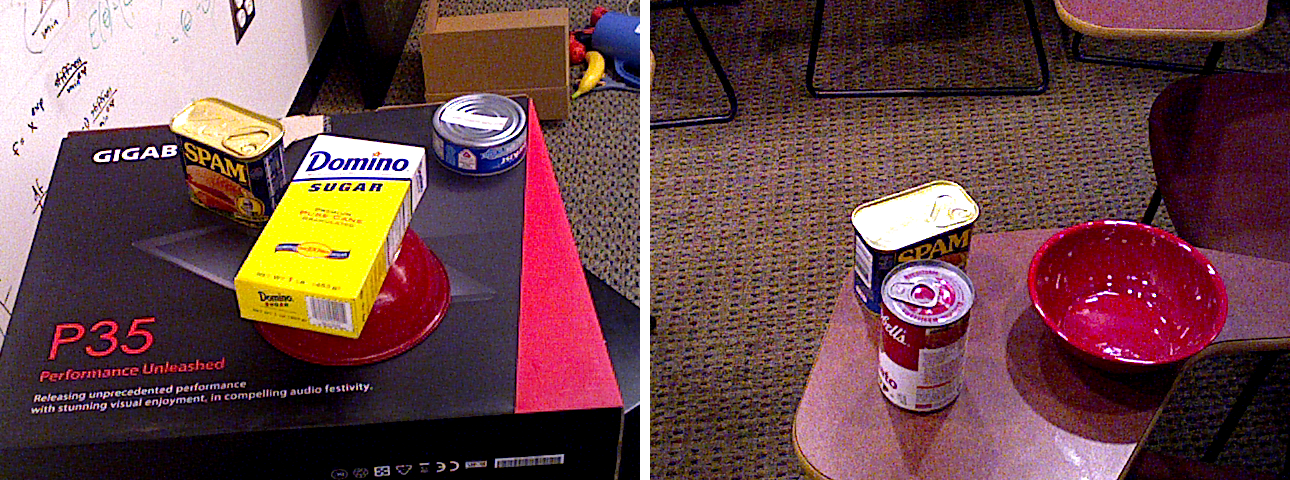

In [4]:
bop_ycb_dir = os.path.join(b.utils.get_assets_dir(), "bop/ycbv")
rgbd, gt_ids, gt_poses, masks = b.ycb_loader.get_test_img('49', '1', bop_ycb_dir)

embeddings = get_features(rgbd)

rgbd2, gt_ids2, gt_poses2, masks2 = b.ycb_loader.get_test_img('49', '1', bop_ycb_dir)
rgbd2, gt_ids2, gt_poses2, masks2 = b.ycb_loader.get_test_img('53', '1', bop_ycb_dir)
embeddings2 = get_features(rgbd2)

b.hstack_images([
    b.get_rgb_image(rgbd.rgb),
    b.get_rgb_image(rgbd2.rgb),
])

In [5]:
object_index = 2
mask = masks[object_index]
coords = jnp.vstack(jnp.where(mask))
key = jax.random.PRNGKey(10)

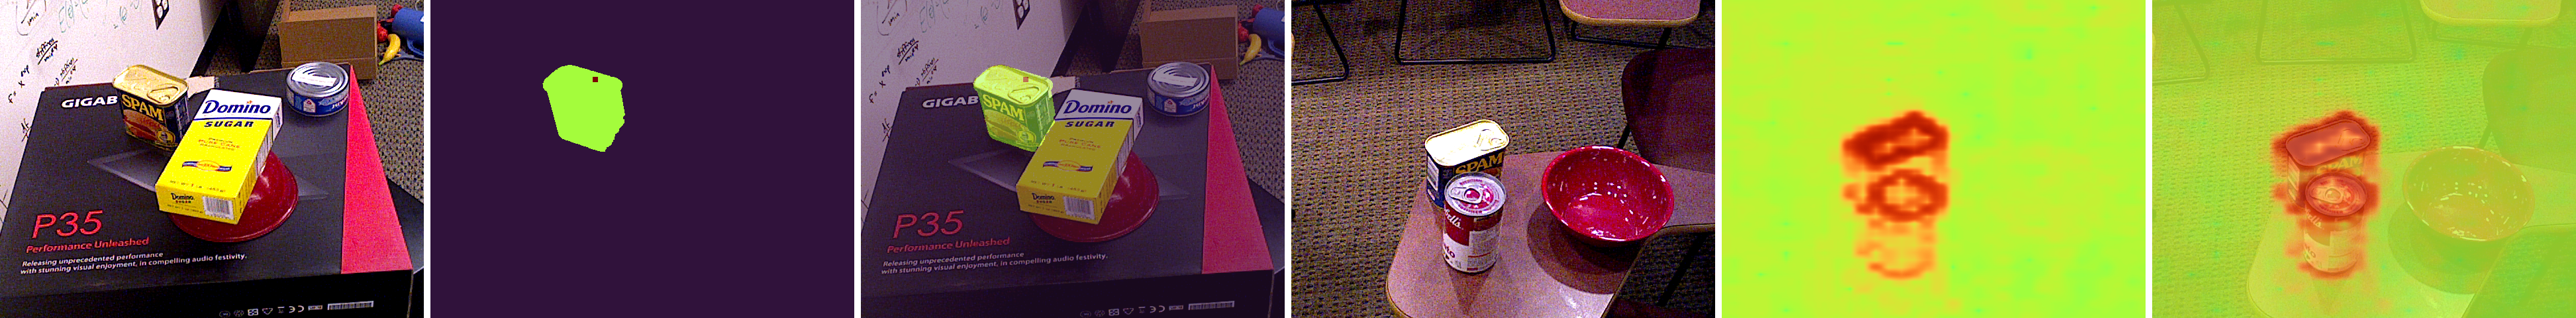

In [7]:
selected_embedding.shape

(1536,)

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, FloatSlider, IntSlider, Button, Output, HBox, VBox


n   = 1_000
x   = np.linspace(0.0,1.0,n)
y   = np.cumsum(np.random.randn(n)*0.1)
out = Output(layout={'border': '5px solid black', "height" : '100px'})


def func(i, sig):
    
    y_ = sig*y
    plt.figure(figsize=(4,4))
    plt.xlim(0,1)
    plt.ylim(np.min(y),np.max(y))
        
    plt.plot(x,y_, c="C0",zorder=1, alpha=0.2)
    plt.plot(x[:i+1],y_[:i+1], c="C0",zorder=1, alpha=0.7)
    plt.scatter(x[i],y_[i], c="magenta", s=100,zorder=2)
    
    with out: 
        out.clear_output()
        display(f"i   = {i}")
        display(f"sig = {sig}")


w = interactive(func, 
    i   = IntSlider(min=0, max=len(x)-1, step=1, value=n//2, description='i:'),
    sig = FloatSlider(min=0.0, max=1.0, value=0.5, description="sigma:")
);
display(VBox([w,out]))